## Transform 2019: Integrating Striplog and GemPy

In [8]:
# Authors: M. de la Varga, Evan Bianco, Brian Burnham and Dieter Werthmüller

# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../")

# Importing GemPy
import gempy as gp


# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt

import welly
from welly import Location, Project
import glob
from striplog import Striplog, Legend, Decor


In [15]:
gp.

<module 'gempy' (namespace)>

#### Creating striplog object
----

In [9]:
# get well header coordinates
well_heads = {'alpha': {'kb_coords':(0,0,0)},
              'beta': {'kb_coords':(10,10,0)}, 
              'gamma': {'kb_coords':(12,0,0)}, 
              'epsilon': {'kb_coords':(20,0,0)}}

In [10]:
# Reading tops file
topsfiles = glob.glob('../data/input_data/striplog_integration/*.tops')
topsfiles

['../data/input_data/striplog_integration/epsilon_strip.tops',
 '../data/input_data/striplog_integration/alpha_strip.tops',
 '../data/input_data/striplog_integration/beta_strip.tops',
 '../data/input_data/striplog_integration/gamma_strip.tops']

In [11]:
# Creating striplog object
my_striplogs = []

for file in topsfiles:
    with open(file) as f:
        text = f.read()
        striplog = Striplog.from_csv(text=text)
        my_striplogs.append(striplog)
        
striplog_dict = {'alpha': my_striplogs[1],
          'beta': my_striplogs[2],  
          'gamma': my_striplogs[3], 
          'epsilon': my_striplogs[0]}
striplog_dict['alpha'][0]

Interval({'top': Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'units': 'm'}), 'base': Position({'middle': 50.0, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lith': 'overburden'})]})

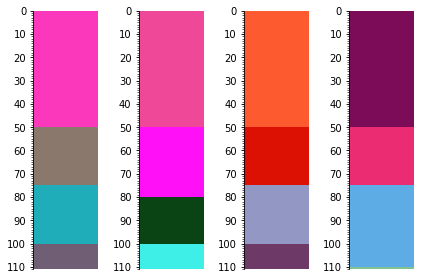

In [12]:
# Plot striplog
f, a = plt.subplots(ncols=4, sharey=True)

for e, log in enumerate(striplog_dict.items()):
    log[1].plot(ax=a[e], legend=None)
f.tight_layout()


In [13]:
# Striplog to pandas df of bottoms
rows = []
for wellname in striplog_dict.keys():
    for i, interval in enumerate(striplog_dict[wellname]):
            surface_name = interval.primary.lith
            surface_base = interval.base.middle
            x,y = well_heads[wellname]['kb_coords'][:-1]
            series = 1
            rows.append([x, y, surface_base, surface_name, series, wellname])
column_names = ['X','Y','Z','surface', 'series','wellname']
df = pn.DataFrame(rows, columns=column_names)
df

,X,Y,Z,surface,series,wellname
0,0,0,50.0,overburden,1,alpha
1,0,0,75.0,miguel,1,alpha
2,0,0,100.0,evan,1,alpha
3,0,0,120.0,brian,1,alpha
4,0,0,121.0,dieter,1,alpha
5,10,10,50.0,overburden,1,beta
6,10,10,80.0,miguel,1,beta
7,10,10,100.0,evan,1,beta
8,10,10,130.0,brian,1,beta
9,10,10,131.0,dieter,1,beta


#### GemPy model
-----

In [14]:
# Create gempy model object
geo_model = gp.create_model('welly_integration')

extent = [-100, 300, -100, 200, -150, 0]
res = [60, 60, 60]

# Initializting model using the striplog df
gp.init_data(geo_model, extent, res, surface_points_df = df)

AttributeError: module 'gempy' has no attribute 'create_model'

In [ ]:
geo_model.surface_points.df.head()

In [ ]:
geo_model.surfaces

In [ ]:
dec_list =[]
for e, i in enumerate(striplog_dict['alpha']):
    dec_list.append(Decor({'_colour': geo_model.surfaces.df.loc[e, 'color'],
  'width': None,
  'component': i.primary,
  'hatch': None}))

In [ ]:
# welly plot with gempy colors
# Create Decor list
dec_list =[]
for e, i in enumerate(striplog_dict['alpha']):
    dec_list.append(Decor({'_colour': geo_model.surfaces.df.loc[e, 'color'],
  'width': None,
  'component': i.primary,
  'hatch': None}))
    
# Create legend
legend = Legend(dec_list)
legend

In [ ]:
# Plot striplogs:
# Plot striplog
f, a = plt.subplots(ncols=4, sharey=True)

for e, log in enumerate(striplog_dict.items()):
    log[1].plot(ax=a[e], legend=legend)
f.tight_layout()

In [ ]:
# Modifying the coordinates to make more sense
geo_model.surface_points.df[['X', 'Y']] = geo_model.surface_points.df[['X', 'Y']] * 10 
geo_model.surface_points.df['Z'] *= -1

In [ ]:
# Delete points of the basement surface since we are intepolating bottoms (that surface wont exit).
geo_model.delete_surface_points_basement()

In [ ]:
# Adding an arbitrary orientation. Remember gempy need an orientation per series
geo_model.set_default_orientation()
geo_model.modify_orientations(0, X=-500)

In [ ]:
gp.plot.plot_data(geo_model)

In [ ]:
# vtk_obj = gp.plot.plot_3D(geo_model, silent=False)

In [ ]:
gp.set_interpolation_data(geo_model)

In [ ]:
gp.compute_model(geo_model)

In [ ]:
# Plotting the interpolated model with the well logs below. Placing the wells in the same coordinate system need
# quite a bit of love yet.

p = gp.plot.plot_section(geo_model, 30,  show_data=True)
axs = p.fig.axes[0]
axis_to_data = axs.transAxes + axs.transData.inverted() 
data_to_axis = axis_to_data.inverted()

for e, log in enumerate(striplog_dict.items()):
    # X coordinates of heads, times 10 because we are rescaling all data. 
    X = (np.array(well_heads[log[0]]['kb_coords'])[[0]] * 10).astype('float')

    # y scale we use the model  height but it is quite arbitrary
    x, y, width, height = data_to_axis.transform((X[0], -230, 1, 1))
    p.fig.add_axes([x, y,0.03, 0.5])
    log[1].plot(ax=p.fig.axes[-1],width=10, legend=legend)





In [ ]:
# vp = gp.plot.plot_3D(geo_model)

## Pinch out model
----
As we can see the 3D model generated above does not honor the forth well lets fix it. First lets add an unconformity: between the yellow and green layer:


In [ ]:
geo_model.add_series('Unconformity')

Now we set the green layer in the second series

In [ ]:
geo_model.map_series_to_surfaces({'Uncomformity':['brian', 'evan', 'dieter']})

Lastly we need to add a dummy orientation to the new series:

In [ ]:
geo_model.add_orientations(-500, 0, -100, 'dieter', [0, 0 , 1])

Now we can compute:

In [ ]:
gp.compute_model(geo_model)

In [ ]:
p = gp.plot.plot_section(geo_model, 30,  show_data=True)
axs = p.fig.axes[0]
axis_to_data = axs.transAxes + axs.transData.inverted() 
data_to_axis = axis_to_data.inverted()

for e, log in enumerate(striplog_dict.items()):
    # X coordinates of heads, times 10 because we are rescaling all data. 
    X = (np.array(well_heads[log[0]]['kb_coords'])[[0]] * 10).astype('float')

    # y scale we use the model  height but it is quite arbitrary
    x, y, width, height = data_to_axis.transform((X[0], -230, 1, 1))
    p.fig.add_axes([x, y,0.03, 0.5])
    log[1].plot(ax=p.fig.axes[-1],width=10, legend=legend)


Getting better but not quite there yet. Since the yellow does not show up in the last well the pinch out has to happen somewhere before so lets add an artifial point to get that shape:

In [ ]:
geo_model.add_surface_points(200, 0, -75, 'evan');

In [ ]:
gp.compute_model(geo_model)
p = gp.plot.plot_section(geo_model, 30,  show_data=True)
axs = p.fig.axes[0]
axis_to_data = axs.transAxes + axs.transData.inverted() 
data_to_axis = axis_to_data.inverted()

for e, log in enumerate(striplog_dict.items()):
    # X coordinates of heads, times 10 because we are rescaling all data. 
    X = (np.array(well_heads[log[0]]['kb_coords'])[[0]] * 10).astype('float')

    # y scale we use the model  height but it is quite arbitrary
    x, y, width, height = data_to_axis.transform((X[0], -230, 1, 1))
    p.fig.add_axes([x, y,0.03, 0.5])
    log[1].plot(ax=p.fig.axes[-1],width=10, legend=legend)


In [ ]:
# gp.save_model(geo_model)